# Imports

In [1]:
import numpy as np
import pandas as pd
import os

from skimage.transform import resize   # Image Processing Library
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc    # Garbage Collector
gc.collect()

import random

import os

# Pytorch

import sklearn

import torch
import torchvision

from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange

import PIL

In [2]:
def thresh(x):
    if x < 0.5:
        return 0
    else:
        return 1
    
thresh = np.vectorize(thresh, otypes=[float]) 

In [3]:
# Class for Datasets using Custom Images

class CustomImageDataset(Dataset):
    def __init__(self, annotations_dir, img_dir, transform=None, target_transform=None):
        self.annotations_dir = annotations_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, os.listdir(self.img_dir)[idx])
        PIL_img = PIL.Image.open(img_path)
        image = ToTensor()(PIL_img)
        image = image[0].unsqueeze(0)
        annotation_path = os.path.join(self.annotations_dir, os.listdir(self.annotations_dir)[idx])
        PIL_annotation = PIL.Image.open(annotation_path)
        annotation = ToTensor()(PIL_annotation)
        annotation = annotation[0].unsqueeze(0)
        annotation = np.transpose(thresh(annotation), (2, 0, 1))
        annotation = ToTensor()(annotation).permute(2, 0, 1)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            annotation = self.target_transform(annotation)
        return image, annotation

# Dataset Preparation

In [4]:
img_dir = "../data/dogs_and_cats/images/"
annotations_dir = "../data/dogs_and_cats/annotations/"

In [5]:
dataset = CustomImageDataset(
    annotations_dir, 
    img_dir,
)

In [6]:
BATCH_SIZE = 10
TEST_SPLIT = 0.1
VALIDATION_SPLIT = 0.2
SHUFFLE_DATASET = True
RANDOM_SEED = 42
WIDTH = 128
HEIGHT = 128

In [7]:
# Train/Test Split

dataset_size = len(dataset)
indices = list(range(dataset_size))
test_split = int(np.floor(TEST_SPLIT * dataset_size) + 1)   # To match train/valid/test divisible by 10
if SHUFFLE_DATASET:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
train_indices, test_indices = indices[test_split:], indices[:test_split]

# Train/Validation Split
train_size = len(train_indices)
valid_split = int(np.floor(VALIDATION_SPLIT * train_size))
if SHUFFLE_DATASET:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(train_indices)
train_indices, val_indices = train_indices[valid_split:], train_indices[:valid_split]


# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, 
                          sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                          sampler=valid_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                         sampler=valid_sampler)

# Unet Setup

In [8]:
use_gpu = torch.cuda.is_available()

In [9]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ConvTranspose2d(in_channels=mid_channel, 
                                     out_channels=out_channels, 
                                     kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        return block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            # torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=256, padding=1),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm2d(512),
            torch.nn.BatchNorm2d(256),
            # torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
            torch.nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2   # Calculate by how much the bypass should be decreased
            bypass = F.pad(bypass, (-c, -c, -c, -c))   # Reduces the bypass by padding -c
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        # print(x.shape, encode_block1.shape, encode_block2.shape, encode_block3.shape, bottleneck1.shape)
        ##print('Decode Block 3')
        # print(bottleneck1.shape, encode_block3.shape)
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        # print(decode_block3.shape)
        ##print('Decode Block 2')
        cat_layer2 = self.conv_decode3(decode_block3)
        # print(cat_layer2.shape, encode_block2.shape)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        ##print(cat_layer1.shape, encode_block1.shape)
        ##print('Final Layer')
        # print(cat_layer1.shape, encode_block1.shape)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        ##print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        # print(final_layer.shape)
        return final_layer

# Model Training

In [10]:
unet = UNet(in_channel=1, out_channel=2)
if use_gpu:
    unet = unet.cuda()

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
unet.load_state_dict(torch.load('unet_dogs_and_cats_sgd_15epoches.pt'))

<All keys matched successfully>

In [13]:
unet.eval()

UNet(
  (conv_encode1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode

# Evaluation

In [14]:
X_train, y_train = next(iter(train_loader))

In [15]:
X_val, y_val = next(iter(valid_loader))

In [16]:
X_test, y_test = next(iter(test_loader))

In [17]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0] + image_arr.argmax(0))
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

### 1. Segmentation on Train Set

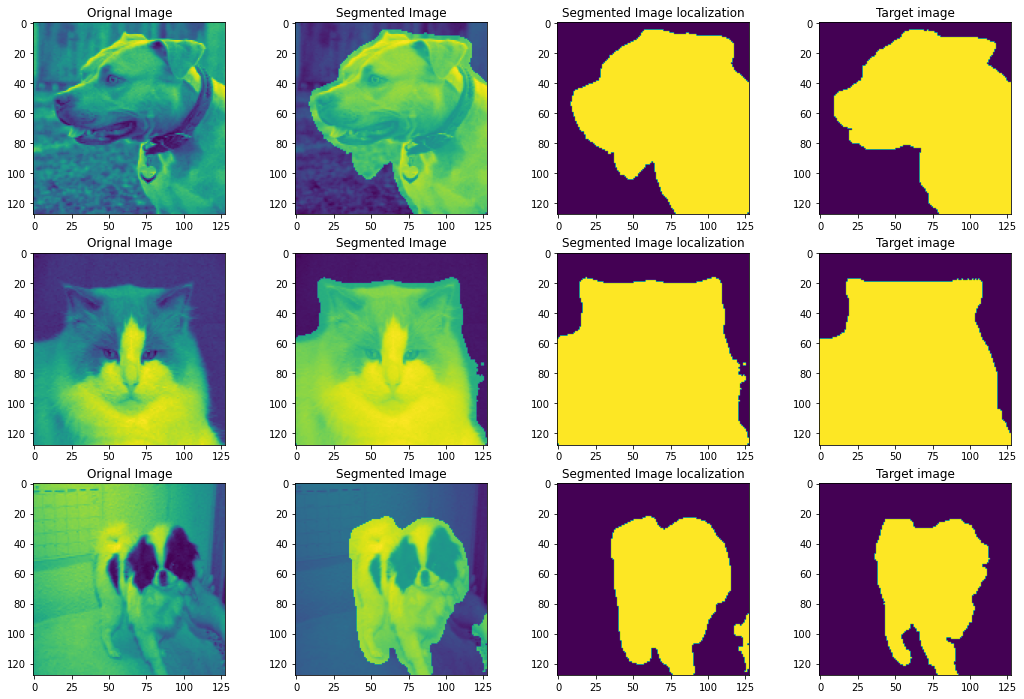

In [18]:
plot_examples(X_train.cpu().numpy(), y_train.cpu().numpy())

### 2. Segmentation on Validation Set

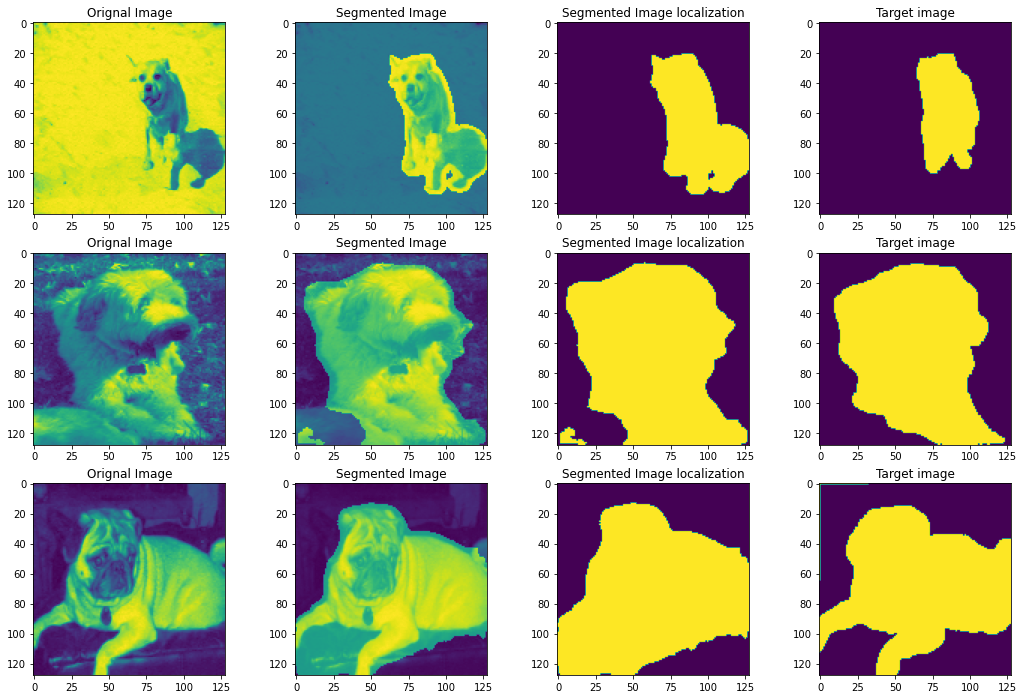

In [19]:
plot_examples(X_val.cpu().numpy(), y_val.cpu().numpy())

### 3. Segmentation on Test Set

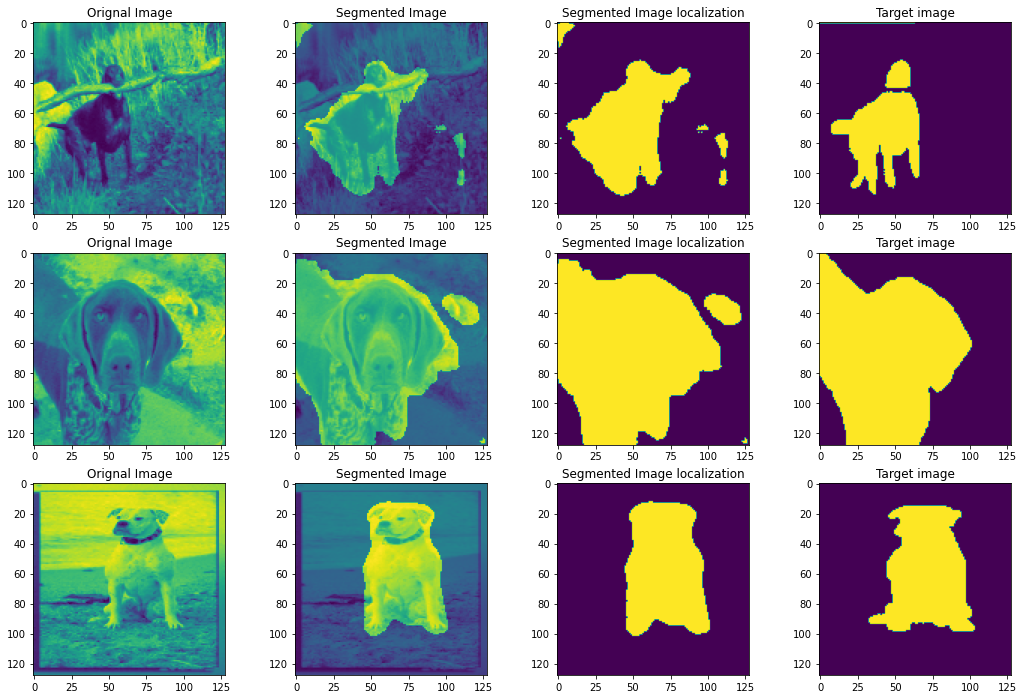

In [20]:
plot_examples(X_test.cpu().numpy(), y_test.cpu().numpy())

### 4. Segmentation on Totally New Pictures

In [21]:
def find_dogs_or_cats(picture_link):
    PIL_img = PIL.Image.open(f"{picture_link}")
    img = ToTensor()(PIL_img)
    img_array = resize(img, (img.shape[0], 128, 128))
    dog_or_cat = np.transpose(img_array, (1, 2, 0))
    img_array = ToTensor()(img_array[0]).unsqueeze(0)
    img_array = img_array.to(device)
    found_you = unet(img_array)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].imshow(dog_or_cat)
    ax[0].set_title("Original Picture")
    ax[1].imshow(img_array.cpu().squeeze(0).squeeze(0) + found_you.detach().cpu().squeeze()[1]);
    ax[1].set_title("Found YOU!!!")

#### One Dog

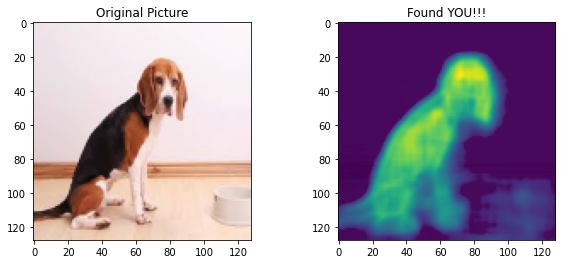

In [22]:
find_dogs_or_cats("../data/one_dog.jpg")

#### Three Dogs

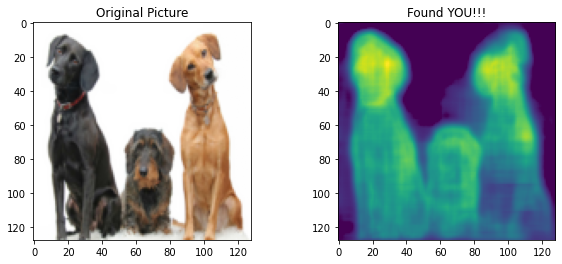

In [23]:
find_dogs_or_cats("../data/three_dogs.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Found YOU!!!')

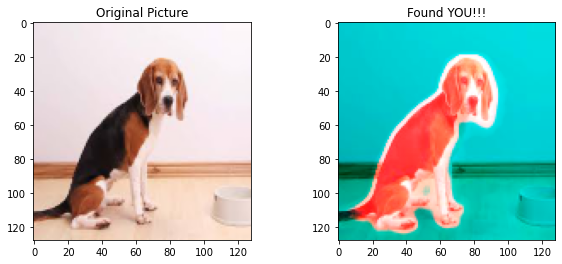

In [24]:
# Testing for Colors

PIL_img = PIL.Image.open("../data/one_dog.jpg")
img = ToTensor()(PIL_img)
img_array = resize(img, (img.shape[0], 128, 128))
dog_or_cat = np.transpose(img_array, (1, 2, 0))
img_array = ToTensor()(img_array[0]).unsqueeze(0)
img_array = img_array.to(device)
found_you = unet(img_array)
found_you = found_you.detach().cpu().squeeze()[1].numpy()

found_you_2 = np.zeros((np.array(found_you).shape[0], np.array(found_you).shape[1], 3))
found_you_2[:,:,0] = found_you   # same value in each channel
found_you_2[:,:,1] = found_you/50
found_you_2[:,:,2] = found_you/50

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].imshow(dog_or_cat)
ax[0].set_title("Original Picture")
ax[1].imshow(dog_or_cat + found_you_2);
ax[1].set_title("Found YOU!!!")